In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm, multivariate_normal
import seaborn as sns

In [2]:
def mutiplyGauss (m1 , s1,  m2 , s2):

  s = 1/(1/s1 + 1/s2)
  m = (m1/s1 + m2/s2)*s

  return m, s

def divideGauss (m1 , s1 , m2 , s2):

  m, s = mutiplyGauss(m1 , s1 , m2 , s2)

  return m, s

def truncGaussMM (a, b, m0 , s0):

  a_scaled , b_scaled = (a - m0)/np.sqrt(s0), (b - m0)/np.sqrt(s0)
  m = truncnorm.mean(a_scaled, b_scaled, loc=m0, scale =np.sqrt(s0))
  s = truncnorm.var(a_scaled, b_scaled, loc=m0, scale =np.sqrt(s0))

  return m, s


In [3]:
def message_passing(y, m1, v1, m2, v2, vt):
    # message from factor f_s1(s1) to node s1
    mu3_m = m1
    mu3_v = v1

    # message from factor f_s2(s2) to node s2
    mu5_m = m2
    mu5_v = v2

    # message from nodes s1 to factor f_st(t)
    mu4_m = mu3_m
    mu4_v = mu3_v
    # message from nodes s1 to factor f_st(t)
    mu6_m = mu5_m
    mu6_v = mu5_v

    # message from factor f_st(t) to node t
    mu7_m = m1-m2
    mu7_v = v1+v2+vt

    # moment matcing
    if y == 1:
        a, b = 0, np.Inf
    else:
        a, b = np.NINF , 0

    pt_m, pt_v = truncGaussMM(a, b, mu7_m, mu7_v)
    # outgoing message from node t to factor f_st(t)
    mu8_m, mu8_v = divideGauss(pt_m,  pt_v, mu7_m, mu7_v)

    # message from factor f_st(t) to node s1
    mu9_m = mu8_m + m2
    mu9_v = mu8_v + vt + v2

    # message from factor f_st(t) to node s2
    mu10_m = m1 - mu8_m
    mu10_v = mu8_v + vt + v1

    # compute the marginal of s1 and s2
    p1_m , p1_v = mutiplyGauss(mu3_m, mu3_v, mu9_m, mu9_v)
    p2_m , p2_v = mutiplyGauss(mu5_m, mu5_v, mu10_m, mu10_v)

    return p1_m , p1_v, p2_m , p2_v

In [4]:
y=1
m1 = 25
m2 = 25
v1 = (25/3)**2
v2 = (25/3)**2
vt = (25/3)**2
p1_m, p1_v, p2_m, p2_v = message_passing(y, m1, v1, m2, v2, vt)
num_samples = 500
burn_in = 20
x = np.linspace(m1-v1, m1+v1, num_samples-burn_in)

s1_pdf = norm.pdf(x,p1_m,np.sqrt(p1_v))
s2_pdf = norm.pdf(x,p2_m,np.sqrt(p2_v))


In [5]:
def sample_t(s1, s2, sigma_t):
    return np.random.normal(s1 - s2, sigma_t)

# Function to sample s = [s1, s2] given t using joint normal
def sample_s_given_t(t, mu_1, mu_2, sigma_1, sigma_2):
    # Compute the conditional means and variances
    variance_s1 = sigma_1**2
    variance_s2 = sigma_2**2

    # Define A matrix and b vector
    A = np.array([[1, -1]])  # For the linear combination t = s1 - s2
    Sigma_s = np.array([[variance_s1, 0], [0, variance_s2]])  # Covariance matrix for s1 and s2
    b = np.array([t])

    # Conditional distribution of s given t
    inv_sigma_t = 1 / (sigma_t**2)  # Inverse of scalar sigma_t^2
    cov_s_given_t = np.linalg.inv(A.T @ A * inv_sigma_t + np.linalg.inv(Sigma_s))
    mean_s_given_t = cov_s_given_t @ (A.T * inv_sigma_t @ b + np.linalg.inv(Sigma_s) @ np.array([mu_1, mu_2]))

    # Draw a sample from the conditional distribution
    return np.random.multivariate_normal(mean_s_given_t, cov_s_given_t)

# Gibbs Sampling with Burn-in
def gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2):
    s1_samples = [initial_s1]
    s2_samples = [initial_s2]
    t_samples = []

    # Iterate to generate samples
    for _ in range(num_samples):
        # Sample t given s1 and s2
        s1_current = s1_samples[-1]
        s2_current = s2_samples[-1]
        t_new = sample_t(s1_current, s2_current, sigma_t)
        t_samples.append(t_new)

        # Sample s = [s1, s2] given t, with rejection if s1 <= s2
        while True:
            s_new = sample_s_given_t(t_new, mu_1, mu_2, sigma_1, sigma_2)
            if s_new[0] > s_new[1]:  # Ensure s1 > s2
                s1_samples.append(s_new[0])
                s2_samples.append(s_new[1])
                break

    # Discard the burn-in samples
    return s1_samples[burn_in:], s2_samples[burn_in:], t_samples[burn_in:]

In [6]:
mu_1 = 25
sigma_1 =25/3
mu_2 = 25
sigma_2 = 25/3
sigma_t = 25/3
initial_s1 = 25
initial_s2 = 25

# Gibbs sampling
s1_samples, s2_samples, _= gibbs_sampling(num_samples, burn_in, initial_s1, initial_s2)

In [7]:
s1_gibbs_pdf = norm.pdf(x,np.mean(s1_samples),np.std(s1_samples))
s2_gibbs_pdf  = norm.pdf(x,np.mean(s2_samples),np.std(s2_samples))

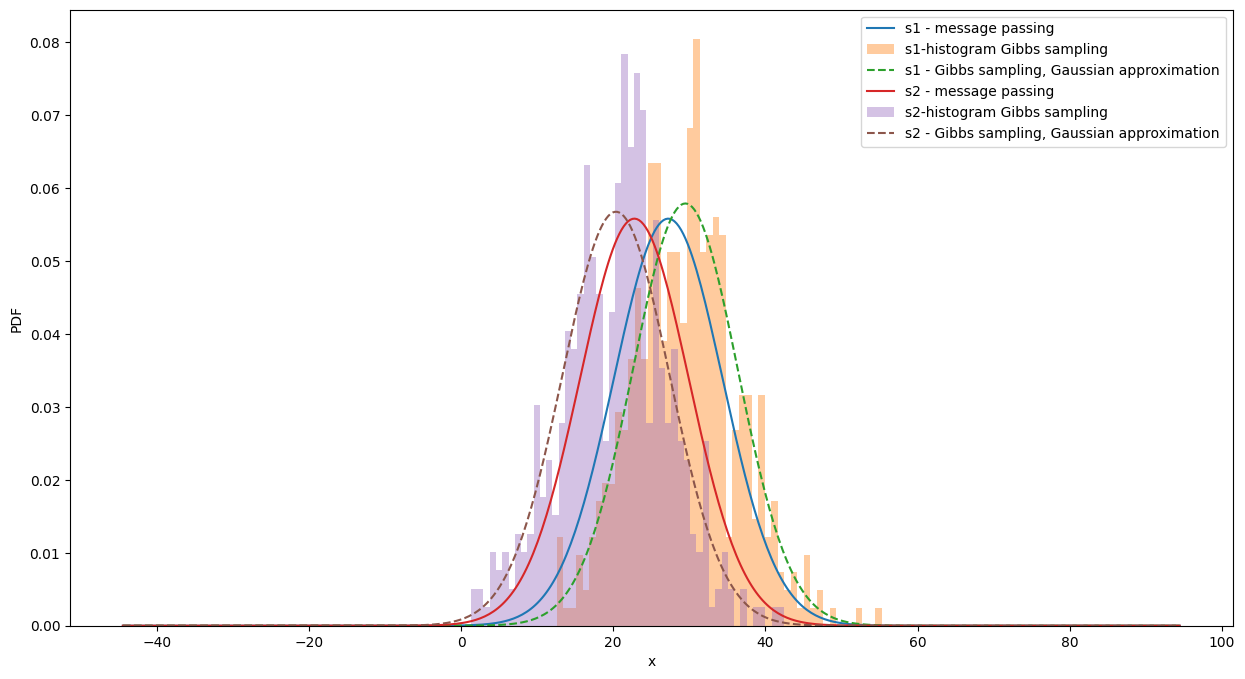

In [9]:
# plot the posteriors computed with message passing, the histogram and the Gaussian approximation from Gibbs sampling for player 1
plt.figure(figsize=(15, 8))
plt.plot(x,s1_pdf,'-',label = 's1 - message passing')
plt.hist(s1_samples, label='s1-histogram Gibbs sampling',density = True,bins=50, alpha = 0.4)
plt.plot(x,s1_gibbs_pdf,'--',label = "s1 - Gibbs sampling, Gaussian approximation")


# plot the posteriors computed with message passing, the histogram and the Gaussian approximation from Gibbs sampling for player 1
plt.plot(x,s2_pdf,'-',label = 's2 - message passing')
plt.hist(s2_samples, label='s2-histogram Gibbs sampling',density = True,bins=50, alpha = 0.4)
plt.plot(x,s2_gibbs_pdf,'--',label = "s2 - Gibbs sampling, Gaussian approximation")

plt.xlabel('x')
plt.ylabel('PDF')
plt.legend()
plt.show()